# Generative Adversarial Network

Uma [Generative Adversarial Network](https://en.wikipedia.org/wiki/Generative_adversarial_network) (GAN) é uma classe de frameworks de machine learning projetada por Ian Goodfellow e seus colegas em 2014. Duas redes neurais competem entre si em um jogo (na forma de um jogo de soma zero, em que o ganho de um agente é a perda de outro).

Dado um conjunto de treinamento, essa técnica aprende a gerar novos dados com as mesmas estatísticas do conjunto de treinamento. Por exemplo, uma GAN treinada em fotografias pode gerar novas fotografias que parecem pelo menos superficialmente autênticas para observadores humanos, com muitas características realistas.

Neste notebook, veremos um exemplo de como podemos criar uma GAN com PyTorch.

Primeiramente vamos então importar as bibliotecas necessárias:

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

Definimos um transformador que fará os valores de pixels entre -1 e +1:

In [3]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,),std=(0.5,))])

Carregamos o conjunto de dados de dígitos numéricos MNIST:

In [4]:
train_dataset = torchvision.datasets.MNIST(
    root = '.',
    train = True,
    transform =transform,
    download  = True
)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Vejamos com quantas amostras estamos lidando:

In [5]:
len(train_dataset)

60000

A seguir, criamos um **DataLoader** a partir de nosso conjunto de dados:

In [6]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size, shuffle=True)

Definimos a nossa rede neural discriminadora:

In [7]:
D = nn.Sequential(
    nn.Linear(784, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
)

Definimos a nossa rede neural geradora:

In [8]:
latent_dim = 100
G = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024, momentum=0.7),
    nn.Linear(1024, 784),
    nn.Tanh()
)

Setamos o dispositivo de processamento disponível:

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
D = D.to(device)
G = G.to(device)

Definimos a função Loss e os Otimizadores:

In [10]:
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

Criamos uma função para retornar as imagens a sua escala original (0,1):

In [11]:
def scale_image(img):
    out = (img + 1) / 2
    return out

Criamos um diretório para armazenar as imagens geradas:

In [12]:
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

E então treinamos a GAN:

In [13]:
# labels to use in the loop
ones_ = torch.ones(batch_size, 1).to(device)
zeros_ = torch.zeros(batch_size, 1).to(device)

# save losses
d_losses = []
g_losses = []

for epoch in range(200):
    for inputs, _ in data_loader:
        # don't need targets

        # reshape and move to GPU
        n = inputs.size(0)
        inputs = inputs.reshape(n, 784).to(device)

        # set ones and zeros to correct size
        ones = ones_[:n]
        zeros = zeros_[:n]


        ###########################
        ### Train discriminator ###
        ###########################

        # real images
        real_outputs = D(inputs)
        d_loss_real = criterion(real_outputs, ones)

        # fake images
        noise = torch.randn(n, latent_dim).to(device)
        fake_images = G(noise)
        fake_outputs = D(fake_images)
        d_loss_fake = criterion(fake_outputs, zeros)

        # gradient descent step
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        #######################
        ### Train generator ###
        #######################

        # do it twice:
        for _ in range(2):
            # fake images
            noise = torch.randn(n, latent_dim).to(device)
            fake_images = G(noise)
            fake_outputs = D(fake_images)

            # reverse the labels!
            g_loss = criterion(fake_outputs, ones)

            # gradient descent step
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

        # save losses
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())


    ### print and save things ###
    print(f"Epoch: {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

    # PyTorch has a function to save a batch of images to file
    fake_images = fake_images.reshape(-1, 1, 28, 28)
    save_image(scale_image(fake_images), f"gan_images/{epoch+1}.png")

Epoch: 0, d_loss: 0.696446418762207, g_loss: 0.7024463415145874
Epoch: 1, d_loss: 0.6792521476745605, g_loss: 0.7582287788391113
Epoch: 2, d_loss: 0.6978943943977356, g_loss: 0.5770364999771118
Epoch: 3, d_loss: 0.6864240169525146, g_loss: 0.7597310543060303
Epoch: 4, d_loss: 0.6816473007202148, g_loss: 0.7532069087028503
Epoch: 5, d_loss: 0.6766785979270935, g_loss: 0.7252835035324097
Epoch: 6, d_loss: 0.6956831216812134, g_loss: 0.7213507890701294
Epoch: 7, d_loss: 0.6780012845993042, g_loss: 0.708427369594574
Epoch: 8, d_loss: 0.6843835115432739, g_loss: 0.7268991470336914
Epoch: 9, d_loss: 0.683853030204773, g_loss: 0.7282597422599792
Epoch: 10, d_loss: 0.6886143088340759, g_loss: 0.7052297592163086
Epoch: 11, d_loss: 0.6784414052963257, g_loss: 0.7104452848434448
Epoch: 12, d_loss: 0.6953577399253845, g_loss: 0.6963197588920593
Epoch: 13, d_loss: 0.6745682954788208, g_loss: 0.7354743480682373
Epoch: 14, d_loss: 0.6913512349128723, g_loss: 0.687524676322937
Epoch: 15, d_loss: 0.694

Plotamos as losses do discriminador e do gerador:

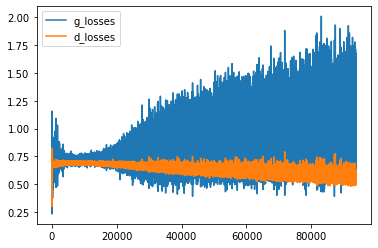

In [14]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend();

E por fim, apresentamos algumas imagens geradas pela GAN:

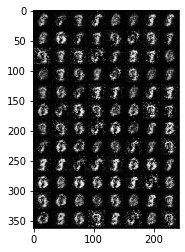

In [15]:
from skimage.io import imread

a = imread('gan_images/1.png')
plt.imshow(a);

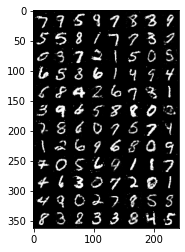

In [16]:
a = imread('gan_images/50.png')
plt.imshow(a);

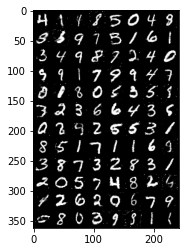

In [17]:
a = imread('gan_images/100.png')
plt.imshow(a);

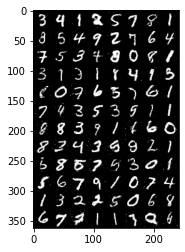

In [19]:
a = imread('gan_images/150.png')
plt.imshow(a);

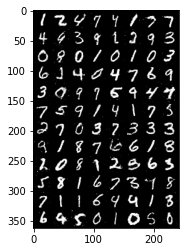

In [20]:
a = imread('gan_images/200.png')
plt.imshow(a);